# Для чего этот блокнот: 


1.   Шпаргалка по основным функциям и возможностям в sql. 
2.   Счастливый билет к свободе от однообразных джойнов и фильтров в тестовых заданиях. 

Все запросы идут в бдшку sqlite3 3.34.1 (в этой вресии уже есть оконные функции) 



# Импорт БД и заливка данных

In [ ]:
!gdown --id 1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
!mv _sqlite3.cpython-37m-x86_64-linux-gnu.so /usr/lib/python3.7/lib-dynload/
import os
os.kill(os.getpid(), 9)

Downloading...
From: https://drive.google.com/uc?id=1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
To: /content/_sqlite3.cpython-37m-x86_64-linux-gnu.so
6.23MB [00:00, 54.9MB/s]


In [1]:
import pandas as pd 
import numpy as np
import sqlite3

In [2]:
sqlite3.sqlite_version

'3.34.1'

In [3]:
con = sqlite3.connect('db')

In [ ]:
PATH_TO_DATA = ''
PATH_TO_TRANSACTIONS = ''

In [4]:
#тут должен быть путь к датасету 
df = pd.read_csv(PATH_TO_DATA)

In [5]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [6]:
df['contract_dt'] = pd.to_datetime(df['contract_dt'],format='%Y-%m-%d %H:%M:%S')

In [7]:
df.dtypes

age                          int64
sex                         object
job                          int64
housing                     object
saving_accounts             object
checking_account            object
credit_amount                int64
duration                     int64
purpose                     object
default                      int64
contract_dt         datetime64[ns]
client_id                    int64
dtype: object

In [8]:
#заливка датасета в бд
df.to_sql('german_credit',con,index=False,if_exists='replace')

# Простые запросы 

In [9]:
# функция отправляет текстовый запрос в бд и возвращает сразу дф
def select(sql):
  return pd.read_sql(sql, con)

In [10]:
#проверка подключения
sql = '''
SELECT 
  t.age * 3 AS age_mult3, 
  t.housing 
FROM 
  german_credit AS t
'''

In [11]:
select(sql)

,age_mult3,housing
0,99,own
1,129,own
2,156,own
3,105,own
4,84,own
...,...,...
995,195,free
996,90,own
997,99,own
998,87,own


In [12]:
sql = '''
SELECT 
  * 
FROM 
  german_credit AS t
'''

In [13]:
select(sql)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,None,None,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,None,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,None,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,None,776,12,radio/TV,0,2007-07-21 13:22:14,358
...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,male,2,free,little,little,2600,18,radio/TV,1,2007-12-16 20:17:19,624
996,30,male,3,own,little,moderate,4455,36,business,1,2007-07-12 14:08:58,181
997,33,male,2,own,little,moderate,6403,24,radio/TV,0,2008-04-08 03:24:26,730
998,29,female,2,own,None,None,5003,21,car,1,2007-11-29 15:51:45,557


In [14]:
sql = ''' 
SELECT 
  t.age, 
  t.housing 
FROM 
  german_credit t
'''

In [15]:
select(sql)

,age,housing
0,33,own
1,43,own
2,52,own
3,35,own
4,28,own
...,...,...
995,65,free
996,30,own
997,33,own
998,29,own


# Группировка

In [16]:
#сводник по полу и размеры кредита
sql = ''' 
SELECT t.sex,
       count(*) AS ppl,
       avg(credit_amount) AS avg_credit,
       max(credit_amount) AS max_credit
FROM german_credit t
GROUP BY t.sex
'''
select(sql)

,sex,ppl,avg_credit,max_credit
0,female,310,2877.774194,18424
1,male,690,3448.040580,15945


In [17]:
#сводники
sql = ''' 
SELECT count(t.client_id) AS clients,
       COUNT(DISTINCT t.client_id) clietns_unique
FROM german_credit t
GROUP BY t.sex
'''
select(sql)

,clients,clietns_unique
0,310,310
1,690,690


# Пропуски и дубликаты

In [18]:
#проверка пропусков с разбивкой по полу
sql = ''' 
SELECT count(t.checking_account) AS rows_without_null,
       count(1) AS rows_with_null,
       count(CASE
                 WHEN t.checking_account IS NULL THEN 1
                 ELSE 0
             END) AS is_null,
       sum(CASE
               WHEN t.checking_account IS NULL THEN 1
               ELSE 0
           END) AS nulls
FROM german_credit t
GROUP BY t.sex
'''
select(sql)

,rows_without_null,rows_with_null,is_null,nulls
0,194,310,310,116
1,412,690,690,278


In [19]:
#замена пропуска
sql = ''' 
SELECT t.checking_account,
       coalesce(t.checking_account, "no_info") AS new_checking_account
FROM german_credit t
'''
select(sql)

,checking_account,new_checking_account
0,None,no_info
1,little,little
2,None,no_info
3,None,no_info
4,None,no_info
...,...,...
995,little,little
996,moderate,moderate
997,moderate,moderate
998,None,no_info


In [20]:
# дубликаты
sql = ''' 
SELECT t.client_id,
       t.contract_dt,
       t.credit_amount,
       count(1) AS COUNT
FROM german_credit t
GROUP BY t.client_id,
         t.contract_dt,
         t.credit_amount
HAVING COUNT > 1
'''
select(sql)
#а тут получается их и нет

,client_id,contract_dt,credit_amount,COUNT


In [21]:
sql = ''' 
SELECT date(t.contract_dt, 'start of month') AS MONTH,
       count(1) AS credits,
       sum(t.credit_amount) AS sum_credits,
       avg(t.credit_amount) AS avg_credit
FROM german_credit t
GROUP BY MONTH
ORDER BY MONTH
'''
select(sql)

,MONTH,credits,sum_credits,avg_credit
0,2007-05-01,81,207663,2563.740741
1,2007-06-01,74,239594,3237.756757
2,2007-07-01,71,224333,3159.619718
3,2007-08-01,57,178569,3132.789474
4,2007-09-01,58,186909,3222.568966
5,2007-10-01,70,188534,2693.342857
6,2007-11-01,87,300504,3454.068966
7,2007-12-01,77,273973,3558.090909
8,2008-01-01,93,288080,3097.634409
9,2008-02-01,55,211128,3838.690909


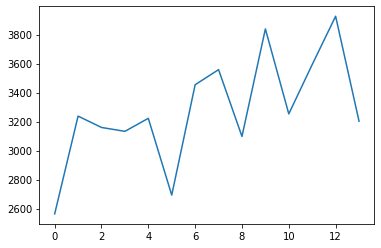

In [22]:
#график средего кредита по месяцам
select(sql)['avg_credit'].plot()

In [23]:
#интервалы через case when then
sql = ''' 
SELECT t.credit_amount,
       CASE
           WHEN t.credit_amount <1000 THEN 1
           WHEN t.credit_amount <2000 THEN 2
           WHEN t.credit_amount >2000 THEN 3
           ELSE 'other'
       END AS credit_amount_bin
FROM german_credit t
'''
select(sql)

,credit_amount,credit_amount_bin
0,3074,3
1,1344,2
2,936,1
3,1393,2
4,776,1
...,...,...
995,2600,3
996,4455,3
997,6403,3
998,5003,3


In [24]:
sql = ''' 
SELECT max(t.credit_amount),
       min(t.credit_amount),
       avg(t.credit_amount)
FROM german_credit t
'''
select(sql)

,max(t.credit_amount),min(t.credit_amount),avg(t.credit_amount)
0,18424,250,3271.258


In [25]:
sql = ''' 
SELECT CASE
           WHEN t.credit_amount <1000 THEN 1
           WHEN t.credit_amount <2000 THEN 2
           WHEN t.credit_amount >2000 THEN 3
           ELSE 'other'
       END AS credit_amount_bin,
       count(*) AS n_of_credit
FROM german_credit t
GROUP BY credit_amount_bin
'''
select(sql)

,credit_amount_bin,n_of_credit
0,1,116
1,2,316
2,3,568


# Сводники

In [26]:
#сводники
sql = ''' 
SELECT t.housing,
       count(CASE
                 WHEN t.sex = 'female' THEN 1
                 ELSE NULL
             END) AS females,
       count(CASE
                 WHEN t.sex = 'male' THEN 1
                 ELSE NULL
             END) AS males,
       count(1)
FROM german_credit t
GROUP BY t.housing
'''
select(sql)

,housing,females,males,count(1)
0,free,19,89,108
1,own,196,517,713
2,rent,95,84,179


In [27]:
#автоматизация сводников 
sql = ''' 
SELECT distinct(t.purpose)
FROM german_credit t
'''
purpose = list(select(sql)['purpose'].values)
select(sql)

,purpose
0,radio/TV
1,car
2,education
3,furniture/equipment
4,repairs
5,business
6,domestic appliances
7,vacation/others


In [28]:
#если вдруг условий очень много, то можно так
for p in purpose:
  print(f"count(case when t.purpose = '{p}' then 1 else null end) as {p.lower().replace(' ', '').replace('/', '')},")

count(case when t.purpose = 'radio/TV' then 1 else null end) as radiotv,
count(case when t.purpose = 'car' then 1 else null end) as car,
count(case when t.purpose = 'education' then 1 else null end) as education,
count(case when t.purpose = 'furniture/equipment' then 1 else null end) as furnitureequipment,
count(case when t.purpose = 'repairs' then 1 else null end) as repairs,
count(case when t.purpose = 'business' then 1 else null end) as business,
count(case when t.purpose = 'domestic appliances' then 1 else null end) as domesticappliances,
count(case when t.purpose = 'vacation/others' then 1 else null end) as vacationothers,


In [29]:
sql = ''' 
SELECT t.housing,
       count(CASE
                 WHEN t.purpose = 'radio/TV' THEN 1
                 ELSE NULL
             END) AS radiotv,
       count(CASE
                 WHEN t.purpose = 'car' THEN 1
                 ELSE NULL
             END) AS car,
       count(CASE
                 WHEN t.purpose = 'education' THEN 1
                 ELSE NULL
             END) AS education,
       count(CASE
                 WHEN t.purpose = 'furniture/equipment' THEN 1
                 ELSE NULL
             END) AS furnitureequipment,
       count(CASE
                 WHEN t.purpose = 'repairs' THEN 1
                 ELSE NULL
             END) AS repairs,
       count(CASE
                 WHEN t.purpose = 'business' THEN 1
                 ELSE NULL
             END) AS business,
       count(CASE
                 WHEN t.purpose = 'domestic appliances' THEN 1
                 ELSE NULL
             END) AS domesticappliances,
       count(CASE
                 WHEN t.purpose = 'vacation/others' THEN 1
                 ELSE NULL
             END) AS vacationothers
FROM german_credit t
GROUP BY t.housing
'''
select(sql)

,housing,radiotv,car,education,furnitureequipment,repairs,business,domesticappliances,vacationothers
0,free,15,55,15,11,3,5,0,4
1,own,227,219,34,122,17,76,10,8
2,rent,38,63,10,48,2,16,2,0


In [30]:
sql = ''' 
SELECT CASE
           WHEN t.purpose like '%bus%' THEN 'бизнес'
           WHEN t.purpose like '%car%' THEN 'тачка'
           ELSE 'other'
       END AS category,
       count(1)
FROM german_credit t
GROUP BY category
'''
select(sql)

,category,count(1)
0,other,566
1,бизнес,97
2,тачка,337


# Подзапросы

In [31]:
#подзапросы 
sql = ''' 
SELECT t.client_id,
       count(1)
FROM
  (SELECT *
   FROM german_credit t
   UNION ALL SELECT *
   FROM
     (SELECT *
      FROM german_credit t
      LIMIT 500)) t
GROUP BY t.client_id
HAVING count(1) >1
'''
select(sql)

,client_id,count(1)
0,0,2
1,1,2
2,4,2
3,5,2
4,9,2
...,...,...
495,992,2
496,993,2
497,996,2
498,998,2


In [32]:
sql = ''' 
DROP TABLE IF EXISTS dupls;


CREATE TABLE dupls AS
SELECT t.client_id,
       count(1)
FROM
  (SELECT *
   FROM german_credit t
   UNION ALL SELECT *
   FROM
     (SELECT *
      FROM german_credit t
      LIMIT 500)) t
GROUP BY t.client_id
HAVING count(1) >1

'''

In [33]:
#добавить таблицу 
cur = con.cursor()
cur.executescript(sql)

In [34]:
select("SELECT * FROM dupls")

,client_id,count(1)
0,0,2
1,1,2
2,4,2
3,5,2
4,9,2
...,...,...
495,992,2
496,993,2
497,996,2
498,998,2


In [35]:
#посмотреть какие таблицы есть в базе данных 
select("SELECT * FROM sqlite_master WHERE type='table';")

,type,name,tbl_name,rootpage,sql
0,table,german_credit,german_credit,2,"CREATE TABLE ""german_credit"" (\n""age"" INTEGER,..."
1,table,dupls,dupls,21,"CREATE TABLE dupls(client_id INT,""count(1)"")"


In [36]:
#представления внутри запросов для удобного чтения 
sql = ''' 
WITH female_free AS
  (SELECT *
   FROM german_credit t
   WHERE t.sex = 'female'
     AND t.housing = 'free')
SELECT *
FROM female_free ff
WHERE ff.duration = 12
'''
select(sql)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,52,female,3,free,None,None,2133,12,car,0,2007-12-09 10:59:30,584
1,55,female,3,free,little,little,2578,12,furniture/equipment,0,2008-05-22 21:01:10,396
2,57,female,1,free,little,None,2748,12,education,0,2008-01-13 03:11:48,263


# Джойны и запросы посложнее

In [37]:
users = pd.DataFrame({'id':[1,2,3],'name':['gleb','jon snow','tyrion']})
items = pd.DataFrame({'user_id':[1,3,3],'item_name':['hleb','gold','wine'],'value':[5,100,20]})
users.to_sql('users',con,index=False,if_exists='replace')
items.to_sql('items',con,index=False,if_exists='replace')

In [38]:
#джойны 
#лефт
sql = ''' 
SELECT *
FROM users t
LEFT JOIN items i ON t.id = i.user_id
'''
select(sql)

,id,name,user_id,item_name,value
0,1,gleb,1.0,hleb,5.0
1,2,jon snow,NaN,None,NaN
2,3,tyrion,3.0,gold,100.0
3,3,tyrion,3.0,wine,20.0


In [39]:
#джойны 
#иннер
sql = ''' 
SELECT *
FROM users t
INNER JOIN items i ON t.id = i.user_id
'''
select(sql)

,id,name,user_id,item_name,value
0,1,gleb,1,hleb,5
1,3,tyrion,3,gold,100
2,3,tyrion,3,wine,20


In [40]:
users = pd.DataFrame({'id':[1,2,3],'name':['gleb','jon snow','tyrion'],
                      'victory':[2,10,1]})

users.to_sql('users',con,index=False,if_exists='replace')

sql = '''
SELECT t.*,
       i.item_name,
       i.value,
       i.user_id
FROM users t
LEFT JOIN items i ON t.id = i.user_id
'''
select(sql)

,id,name,victory,item_name,value,user_id
0,1,gleb,2,hleb,5.0,1.0
1,2,jon snow,10,None,NaN,NaN
2,3,tyrion,1,gold,100.0,3.0
3,3,tyrion,1,wine,20.0,3.0


In [41]:
sql = '''
SELECT * from USERS t
'''
select(sql)

,id,name,victory
0,1,gleb,2
1,2,jon snow,10
2,3,tyrion,1


In [42]:
sql = '''SELECT * FROM items t'''
select(sql)

,user_id,item_name,value
0,1,hleb,5
1,3,gold,100
2,3,wine,20


In [43]:
sql = '''
SELECT *
FROM users u
INNER JOIN items i ON u.id = i.user_id
'''
select(sql)

,id,name,victory,user_id,item_name,value
0,1,gleb,2,1,hleb,5
1,3,tyrion,1,3,gold,100
2,3,tyrion,1,3,wine,20


In [104]:
#кросс джойн - n*m, где n,m- количество строк в каждой таблице
sql = '''
SELECT *
FROM users u
INNER JOIN items i ON 1=1
'''
select(sql)

,id,name,victory,user_id,item_name,value
0,1,gleb,2,1,hleb,5
1,1,gleb,2,3,gold,100
2,1,gleb,2,3,wine,20
3,2,jon snow,10,1,hleb,5
4,2,jon snow,10,3,gold,100
5,2,jon snow,10,3,wine,20
6,3,tyrion,1,1,hleb,5
7,3,tyrion,1,3,gold,100
8,3,tyrion,1,3,wine,20


In [105]:
german_credit_transactions = pd.read_csv(PATH_TO_TRANSACTIONS)

In [106]:
german_credit_transactions

,dt,client_id,amount
0,2008-04-06 11:54:47,950,161.38
1,2007-07-28 00:00:19,418,35.34
2,2008-03-14 20:43:54,131,146.50
3,2007-12-18 13:03:24,353,119.21
4,2007-11-09 05:18:30,849,105.24
...,...,...,...
4270,2007-08-18 04:05:05,185,10063.07
4271,2007-06-04 15:23:32,375,156.91
4272,2007-12-06 21:34:06,418,10053.82
4273,2008-04-19 17:30:07,409,10050.35


In [107]:
german_credit_transactions.to_sql('client_transactions', con, index = False, if_exists= 'replace')

In [48]:
sql = '''
SELECT date(t.dt, 'start of month') AS MONTH,
       count(1) AS transactions_cnt
FROM client_transactions t
GROUP BY MONTH
'''

In [49]:
select(sql)

,month,transactions_cnt
0,2007-05-01,338
1,2007-06-01,379
2,2007-07-01,304
3,2007-08-01,255
4,2007-10-01,332
5,2007-11-01,389
6,2007-12-01,364
7,2008-01-01,413
8,2008-02-01,228
9,2008-03-01,309


In [108]:
sql = '''
SELECT date(t.dt, 'start of month') AS MONTH,
       count(1) AS transactions_cnt,
       sum(t.amount) AS amount_sum
FROM client_transactions t
GROUP BY MONTH
'''
select(sql)

,MONTH,transactions_cnt,amount_sum
0,2007-05-01,338,450912.77
1,2007-06-01,379,551664.83
2,2007-07-01,304,494134.50
3,2007-08-01,255,426903.23
4,2007-10-01,332,634846.49
5,2007-11-01,389,500420.98
6,2007-12-01,364,561449.89
7,2008-01-01,413,630137.22
8,2008-02-01,228,337043.47
9,2008-03-01,309,425599.09


пропал сентябрь с таким запросом, хотя должен был быть нулевым 

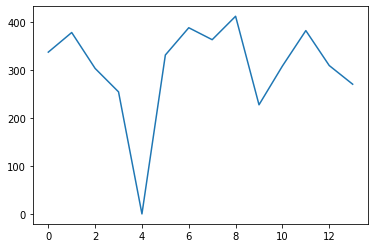

In [109]:
sql = '''
WITH RECURSIVE dates(MONTH) AS
  (
   VALUES('2007-05-01')
   UNION ALL SELECT date(MONTH, '+1 month')
   FROM dates
   WHERE MONTH < '2008-06-01'),
               trans_month AS
  (SELECT date(t.dt, 'start of month') AS MONTH,
          count(1) AS transactions_cnt,
          sum(t.amount) AS amount_sum
   FROM client_transactions t
   GROUP BY MONTH)
SELECT d.month,
       coalesce(t.transactions_cnt, 0) AS transaction_cnt,
       coalesce(t.amount_sum, 0) AS SUM
FROM dates d
LEFT JOIN trans_month t ON d.month = t.month
'''

select(sql)['transaction_cnt'].plot()

In [110]:
sql = '''
--список месяцев
WITH RECURSIVE dates(MONTH) AS
  (
   VALUES('2007-05-01')
   UNION ALL SELECT date(MONTH, '+1 month')
   FROM dates
   WHERE MONTH < '2008-06-01' ), --клиенты
clients AS
  (SELECT distinct(t.client_id)
   FROM german_credit t),
                                          clients_month AS
  (SELECT d.month,
          c.client_id
   FROM dates d
   JOIN clients c ON 1=1),
                                          trans_month AS
  (SELECT date(t.dt, 'start of month') AS MONTH,
          t.client_id,
          count(1) AS transactions_cnt,
          sum(t.amount) AS amount_sum
   FROM client_transactions t
   GROUP BY MONTH,
            t.client_id
   ORDER BY MONTH),
                                          client_trans_month AS
  (SELECT *,
          CASE
              WHEN tm.amount_sum > 0 THEN 1
          END AS active,
          1 AS USER
   FROM clients_month cm
   LEFT JOIN trans_month tm ON cm.client_id = tm.client_id
   AND cm.month = tm.month),
                                          report AS
  (SELECT t.month,
          sum(t.user),
          coalesce(sum(t.active), 0),
          sum(t.amount_sum) AS SUM
   FROM client_trans_month t
   GROUP BY t.month) --select sum(amount) from client_transactions -проверка итоговой суммы

SELECT sum(SUM)
FROM report
'''

select(sql)

,sum(SUM)
0,6548980.62


In [53]:
t = pd.DataFrame({'dt':pd.to_datetime(['2021-04-01','2021-04-02','2021-04-03'],format='%Y-%m-%d'),
                  'revenue':[1,2,3]})

t.to_sql('revenue',con,index=False,if_exists='replace')



In [54]:
sql = '''
SELECT t.dt,
       t.revenue,
       sum(r.revenue) AS cumsum
FROM revenue t
JOIN revenue r ON r.dt <= t.dt
GROUP BY t.dt,
         t.revenue
'''
select(sql)

,dt,revenue,cumsum
0,2021-04-01 00:00:00,1,1
1,2021-04-02 00:00:00,2,3
2,2021-04-03 00:00:00,3,6


# Оконные функции

In [111]:
#накопительная сумма
sql = '''
SELECT t.*,
       sum(t.revenue) OVER (ORDER BY t.dt) AS cum_sum
FROM revenue t
'''

In [56]:
select(sql)

,dt,revenue,cum_sum
0,2021-04-01 00:00:00,1,1
1,2021-04-02 00:00:00,2,3
2,2021-04-03 00:00:00,3,6


In [57]:
t = pd.DataFrame({'user_id':[1,1,1,2,2,2],'dt':pd.to_datetime(['2021-04-01','2021-04-02','2021-04-03',
                                                               '2021-04-01','2021-04-02','2021-04-03'],format='%Y-%m-%d'),
                  'revenue':[1,2,3,2,3,4]})

In [58]:
t

,user_id,dt,revenue
0,1,2021-04-01,1
1,1,2021-04-02,2
2,1,2021-04-03,3
3,2,2021-04-01,2
4,2,2021-04-02,3
5,2,2021-04-03,4


In [59]:
t.to_sql('revenue',con,index=False,if_exists='replace')

In [112]:
sql = '''
SELECT t.*,
       sum(t.revenue) OVER (PARTITION BY t.user_id
                            ORDER BY t.dt) AS cum_sum
FROM revenue t
'''

In [61]:
select(sql)

,user_id,dt,revenue,cum_sum
0,1,2021-04-01 00:00:00,1,1
1,1,2021-04-02 00:00:00,2,3
2,1,2021-04-03 00:00:00,3,6
3,2,2021-04-01 00:00:00,2,2
4,2,2021-04-02 00:00:00,3,5
5,2,2021-04-03 00:00:00,4,9


## Rank и row_number

In [62]:
t = pd.DataFrame({'user_id':[1,1,1,1,2,2,2],'dt':pd.to_datetime(['2021-04-01','2021-04-02','2021-04-03','2021-04-03',
                                                               '2021-04-03','2021-04-04','2021-04-05'],format='%Y-%m-%d'),
                  'revenue':[1,2,3,1,2,3,4]})

In [63]:
t.to_sql('revenue',con,index=False,if_exists='replace')

In [113]:
sql = '''SELECT * FROM revenue t'''

In [114]:
select(sql)

,user_id,dt,revenue
0,1,1,1
1,1,2,2
2,1,3,3
3,1,4,4
4,1,5,5
5,1,6,6
6,2,1,3
7,2,2,4
8,2,3,5
9,2,4,6


In [115]:
sql = '''
SELECT t.*,
       rank() OVER (PARTITION BY t.user_id
                    ORDER BY t.dt DESC) AS rnk
FROM revenue t
'''

In [116]:
select(sql)

,user_id,dt,revenue,rnk
0,1,6,6,1
1,1,5,5,2
2,1,4,4,3
3,1,3,3,4
4,1,2,2,5
5,1,1,1,6
6,2,5,7,1
7,2,4,6,2
8,2,3,5,3
9,2,2,4,4


In [117]:
sql = '''
WITH dt_rank AS
  (SELECT t.*,
          rank() OVER (PARTITION BY t.user_id
                       ORDER BY t.dt DESC) AS rnk
   FROM revenue t)
SELECT *
FROM dt_rank t
WHERE t.rnk = 1
'''

In [71]:
select(sql)

,user_id,dt,revenue,rnk
0,1,2021-04-03 00:00:00,3,1
1,1,2021-04-03 00:00:00,1,2
2,1,2021-04-02 00:00:00,2,3
3,1,2021-04-01 00:00:00,1,4
4,2,2021-04-05 00:00:00,4,1
5,2,2021-04-04 00:00:00,3,2
6,2,2021-04-03 00:00:00,2,3


In [120]:
sql = '''
WITH dt_rank AS
  (SELECT t.*,
          row_number() OVER (PARTITION BY t.user_id
                             ORDER BY t.dt DESC) AS rnk
   FROM revenue t)
SELECT *
FROM dt_rank t
WHERE t.rnk = 1

 '''

In [121]:
select(sql)

,user_id,dt,revenue,rnk
0,1,6,6,1
1,2,5,7,1


In [74]:
t = pd.DataFrame({'user_id':[1,1,1,2,2,2],'dt':pd.to_datetime(['2021-04-01','2021-04-02','2021-04-03',
                                                               '2021-04-03','2021-04-04','2021-04-05'],format='%Y-%m-%d'),
                  'revenue':[1,2,3,2,3,4]})

In [75]:
t.to_sql('revenue',con,index=False,if_exists='replace')

In [123]:
sql = '''SELECT t.user_id,
       max(t.dt) AS max_dt
FROM revenue t
GROUP BY t.user_id'''

In [124]:
select(sql)

,user_id,max_dt
0,1,6
1,2,5


In [125]:
sql = '''

WITH last_dt AS
  (SELECT t.user_id,
          max(t.dt) AS max_dt
   FROM revenue t
   GROUP BY t.user_id)
SELECT t.*
FROM revenue t
JOIN last_dt ld ON t.user_id = ld.user_id
AND t.dt = ld.max_dt

'''

In [126]:
select(sql)

,user_id,dt,revenue
0,1,6,6
1,2,5,7


## Топы

In [80]:
t = pd.DataFrame({'dep':['a','a','a','a','a',
                         'b','b','b','b','b'],
                  'emp':['aa','bb','cc','dd','ee',
                         'aa','bb','cc','dd','ee'],
                  'sal':[5,5,3,2,1,
                         5,4,3,2,1]})

In [81]:
t

,dep,emp,sal
0,a,aa,5
1,a,bb,5
2,a,cc,3
3,a,dd,2
4,a,ee,1
5,b,aa,5
6,b,bb,4
7,b,cc,3
8,b,dd,2
9,b,ee,1


In [82]:
t.to_sql('salary',con,index=False,if_exists='replace')

In [127]:
sql = '''
SELECT t.*,
       rank() OVER (PARTITION BY t.dep
                    ORDER BY t.sal DESC) AS rnk_rank,
                   dense_rank() OVER (PARTITION BY t.dep
                                      ORDER BY t.sal DESC) AS rnk
FROM salary t
'''

In [128]:
select(sql)

,dep,emp,sal,rnk_rank,rnk
0,a,aa,5,1,1
1,a,bb,5,1,1
2,a,cc,3,3,2
3,a,dd,2,4,3
4,a,ee,1,5,4
5,b,aa,5,1,1
6,b,bb,4,2,2
7,b,cc,3,3,3
8,b,dd,2,4,4
9,b,ee,1,5,5


In [129]:
sql = '''

WITH salary_rnk AS
  (SELECT t.*,
          dense_rank() OVER (PARTITION BY t.dep
                             ORDER BY t.sal DESC) AS rnk
   FROM salary t)
SELECT *
FROM salary_rnk t
WHERE t.rnk <= 3


 '''

In [86]:
select(sql)

,dep,emp,sal,rnk
0,a,aa,5,1
1,a,bb,5,1
2,a,cc,3,2
3,a,dd,2,3
4,b,aa,5,1
5,b,bb,4,2
6,b,cc,3,3


## Клиентские сессии

In [87]:
user1 = pd.DataFrame({'user_id':[1,1,1,1,1],
                  'dt':pd.to_datetime(['2021-04-01 07:31','2021-04-01 07:35',
                                       '2021-04-01 08:20','2021-04-01 12:31',
                                       '2021-04-03 07:31'],format='%Y-%m-%d %H:%M')})

In [88]:
user1

,user_id,dt
0,1,2021-04-01 07:31:00
1,1,2021-04-01 07:35:00
2,1,2021-04-01 08:20:00
3,1,2021-04-01 12:31:00
4,1,2021-04-03 07:31:00


In [89]:
user2 = pd.DataFrame({'user_id':[2,2,2,2],
                  'dt':pd.to_datetime(['2021-04-01 07:31','2021-04-01 07:35',
                                       '2021-04-01 08:20','2021-04-01 9:10',
                                       ],format='%Y-%m-%d %H:%M')})

In [90]:
user3 = pd.DataFrame({'user_id':[3,3,3],
                  'dt':pd.to_datetime(['2021-04-01 07:31','2021-04-02 07:35',
                                       '2021-04-03 08:20'
                                       ],format='%Y-%m-%d %H:%M')})

In [91]:
t = pd.concat([user1,user2,user3])

In [92]:
t

,user_id,dt
0,1,2021-04-01 07:31:00
1,1,2021-04-01 07:35:00
2,1,2021-04-01 08:20:00
3,1,2021-04-01 12:31:00
4,1,2021-04-03 07:31:00
0,2,2021-04-01 07:31:00
1,2,2021-04-01 07:35:00
2,2,2021-04-01 08:20:00
3,2,2021-04-01 09:10:00
0,3,2021-04-01 07:31:00


In [93]:
t.to_sql('client_log',con,index=False,if_exists='replace')

In [130]:
sql = '''SELECT * FROM client_log t'''

In [131]:
select(sql)

,user_id,dt
0,1,2021-04-01 07:31:00
1,1,2021-04-01 07:35:00
2,1,2021-04-01 08:20:00
3,1,2021-04-01 12:31:00
4,1,2021-04-03 07:31:00
5,2,2021-04-01 07:31:00
6,2,2021-04-01 07:35:00
7,2,2021-04-01 08:20:00
8,2,2021-04-01 09:10:00
9,3,2021-04-01 07:31:00


In [96]:
24 * 60 * 60

86400

In [132]:
sql = '''
WITH new_session AS
  (SELECT t.*,
          lag(t.dt) OVER (PARTITION BY t.user_id
                          ORDER BY t.dt) AS prev_dt,
                         round((julianday(t.dt) - julianday(lag(t.dt) OVER (PARTITION BY t.user_id
                                                                            ORDER BY t.dt))) * 24 * 60 * 60) AS dt_diff,
                         CASE
                             WHEN round((julianday(t.dt) - julianday(lag(t.dt) OVER (PARTITION BY t.user_id
                                                                                     ORDER BY t.dt))) * 24 * 60 * 60) >= 3600 THEN 1
                             ELSE 0
                         END AS new_session
   FROM client_log t),
     client_sessions AS
  (SELECT t.*,
          sum(t.new_session) OVER (PARTITION BY t.user_id
                                   ORDER BY t.dt) AS session_id
   FROM new_session t),
     client_sessions_agg AS
  (SELECT t.user_id,
          t.session_id,
          count(1) AS action_cnt
   FROM client_sessions t
   GROUP BY t.user_id,
            t.session_id)
SELECT count(*)
FROM client_sessions_agg t
 '''

In [133]:
select(sql)

,count(*)
0,7


## Скользящее среднее

In [99]:
t = pd.DataFrame({'user_id':[1,1,1,1,1,1,
                             2,2,2,2,2],
                  'dt':[1,2,3,4,5,6,
                        1,2,3,4,5],
                  'revenue':[1,2,3,4,5,6,
                             3,4,5,6,7]})

In [100]:
t.to_sql('revenue',con,index=False,if_exists='replace')

In [134]:
sql = '''
SELECT t.*,
       avg(t.revenue) OVER (PARTITION BY t.user_id
                            ORDER BY t.dt ROWS BETWEEN 2 preceding AND CURRENT ROW) AS moving_avg
FROM revenue t
'''

In [102]:
select(sql)

,user_id,dt,revenue,moving_avg
0,1,1,1,1.0
1,1,2,2,1.5
2,1,3,3,2.0
3,1,4,4,3.0
4,1,5,5,4.0
5,1,6,6,5.0
6,2,1,3,3.0
7,2,2,4,3.5
8,2,3,5,4.0
9,2,4,6,5.0
